In [6]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
import tensorflow
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import pickle
nltk.download("wordnet")
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nsoyf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nsoyf\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nsoyf\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nsoyf\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [8]:
df = pd.read_csv("spam_dataset.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [10]:
df.isnull().sum()

Category    0
Message     0
dtype: int64

In [11]:
len(df) - len(df.drop_duplicates())

415

In [12]:
df.drop_duplicates(inplace = True)

<AxesSubplot:ylabel='Category'>

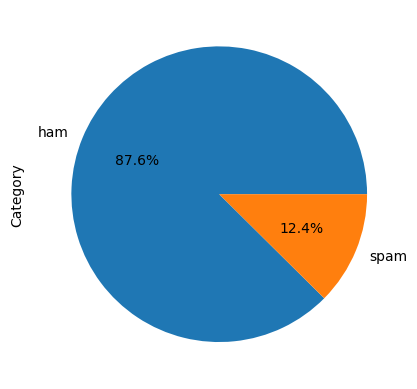

In [13]:
ratio_spam_and_ham = df["Category"].value_counts()
ratio_spam_and_ham.plot.pie(autopct = '%1.1f%%')

Featured words in spam messages:


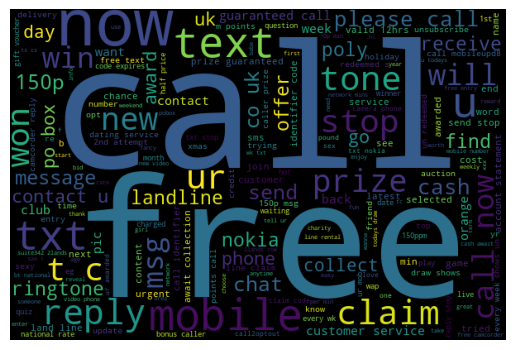

Featured words in non-spam messages:


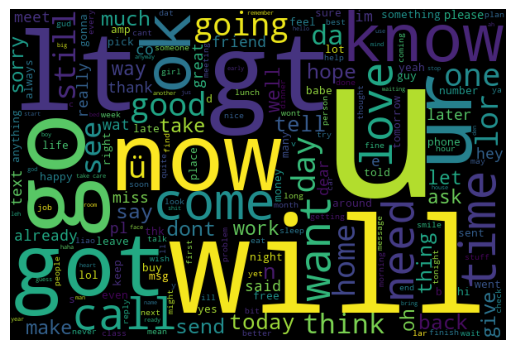

In [15]:
from wordcloud import WordCloud
def visualize(label):
    words=''
    for msg in df[df['Category'] == label]['Message']:
        msg = msg.lower()
        words+=msg + ''
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Featured words in spam messages:")
visualize('spam')

print("Featured words in non-spam messages:")
visualize('ham')

In [16]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]+', ' ', text)
    text = re.sub(r'[0-9]', '', text)
    translator = str.maketrans("", "", string.punctuation)
    text = text.translate(translator)
    words = word_tokenize(text)
    words = [word for word in words if word not in stopwords.words("english")]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    text = " ".join(words)
    return text

In [17]:
df["Message"] = df.Message.map(preprocess) 

In [19]:
maxSeq = len(df["Message"][0])
for i in range (0,len(df["Message"])):
    try:
        cur = len(df["Message"][i])
        if (cur > maxSeq):
            maxSeq = cur
    except:
        pass

In [26]:
from collections import Counter

def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.Message)

MAX_NB_WORDS = len(counter)
MAX_SEQUENCE_LENGTH = maxSeq

In [21]:
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df['Message'].values)
with open("tokenizer.pickle", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5157, 442)


In [23]:
from sklearn import preprocessing
labelencoder = preprocessing.LabelEncoder()
df['Category'] = labelencoder.fit_transform(df['Category'])
Y = df['Category'].values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5157,)


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print('Shapes are the next one: ', X_train.shape,Y_train.shape)
print('Shapes are the next one: ', X_test.shape,Y_test.shape)

Shapes are the next one:  (3867, 442) (3867,)
Shapes are the next one:  (1290, 442) (1290,)


In [27]:
import tensorflow 
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [28]:
model = tensorflow.keras.models.Sequential()
model.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train,
                    Y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', 
                                             patience=3, 
                                             min_delta=0.0001)])

Epoch 1/5
49/49 [==============================] - 22s 381ms/step - loss: 0.3991 - accuracy: 0.8713 - val_loss: 0.2142 - val_accuracy: 0.9276
Epoch 2/5
49/49 [==============================] - 14s 290ms/step - loss: 0.1199 - accuracy: 0.9683 - val_loss: 0.0887 - val_accuracy: 0.9780
Epoch 3/5
49/49 [==============================] - 13s 261ms/step - loss: 0.0543 - accuracy: 0.9903 - val_loss: 0.0626 - val_accuracy: 0.9806
Epoch 4/5
49/49 [==============================] - 13s 266ms/step - loss: 0.0283 - accuracy: 0.9961 - val_loss: 0.0541 - val_accuracy: 0.9832
Epoch 5/5
49/49 [==============================] - 13s 273ms/step - loss: 0.0173 - accuracy: 0.9977 - val_loss: 0.0528 - val_accuracy: 0.9832


In [29]:
print(history.model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 442, 100)          707100    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 724,157
Trainable params: 724,157
Non-trainable params: 0
_________________________________________________________________
None


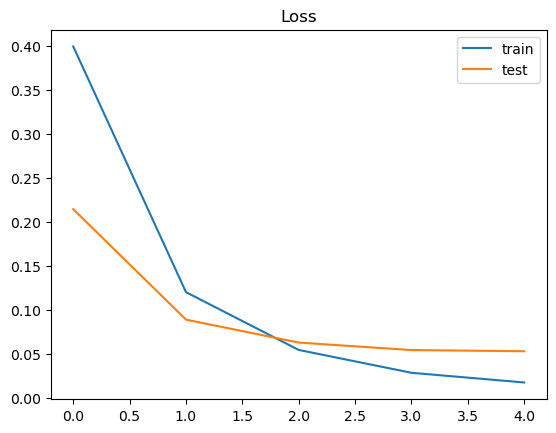

In [30]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

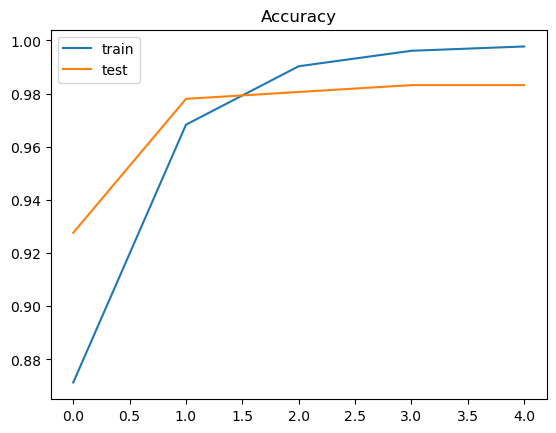

In [31]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [32]:
threshold = 0.5

result = model.predict(X_test, verbose=2)
result = result > threshold
result = result.astype(int)

41/41 - 3s - 3s/epoch - 63ms/step


In [33]:
from sklearn.metrics import classification_report
target_names = ['ham','spam']
print(classification_report(Y_test, result, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1124
        spam       0.93      0.92      0.92       166

    accuracy                           0.98      1290
   macro avg       0.96      0.96      0.96      1290
weighted avg       0.98      0.98      0.98      1290



In [36]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, result)
cm_df = pd.DataFrame(cm,
                     index = target_names, 
                     columns = target_names)

In [37]:
cm_df # showing results

,ham,spam
ham,1112,12
spam,13,153


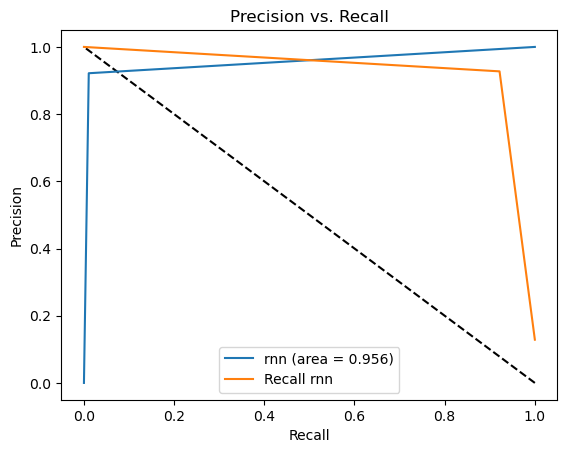

In [38]:
fpr_en, tpr_en, thresholds_en = metrics.roc_curve(Y_test, result)
roc_auc_en = metrics.auc(fpr_en, tpr_en)
precision_en, recall_en, th_en = metrics.precision_recall_curve(Y_test, result)
plt.plot([1, 0], [0, 1], 'k--')
plt.plot(fpr_en, tpr_en, label='rnn (area = %0.3f)' % roc_auc_en)
plt.plot(recall_en,precision_en , label='Recall rnn')
plt.title('Precision vs. Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

In [39]:
model.save("rnn_model.h5")

In [42]:
from keras.models import load_model
loadedModel = load_model("rnn_model.h5")
testText = str(input("Please , Enter Message\n"))
testText = preprocess(testText)
testText = [testText]
with open("./tokenizer.pickle", "rb") as handle:
    tokenizer = pickle.load(handle)
testText = tokenizer.texts_to_sequences(testText)
testText = pad_sequences(testText, maxlen=MAX_SEQUENCE_LENGTH)
threshold = 0.5
result = model.predict(testText, verbose=2)
result = result > threshold
result = result.astype(int)
if result[0] == 1:
    print("Spam")
elif result[0] == 0:
    print("Ham")

Please , Enter Message
Free entry in 2 a wkly comp to win FA Cup spam
1/1 - 0s - 39ms/epoch - 39ms/step
Spam
